In [2]:
pip install seaborn scikit-learn matplotlib

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached pillow-11.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.4 MB)
  Using cached kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached contourpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (324 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.54.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
Note: you may need to restart the kernel to

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn import metrics

In [2]:
# Get Training Data and Holdout data
path_to_train_holdout = 'ml_data_train_holdout/'
files = list(Path(path_to_train_holdout).glob('*.parquet'))
print(files)
training_file = files[0]
training_data = pd.read_parquet(training_file)
training_data.head()
holdout_file = files[1]
holdout_data = pd.read_parquet(holdout_file)
holdout_data.head()
print(f'Amount of Training Data: {len(training_data)}')
print(f'Amount of Testing Data: {len(holdout_data)}')

[PosixPath('ml_data_train_holdout/train_set.parquet'), PosixPath('ml_data_train_holdout/holdout_set.parquet')]
Amount of Training Data: 52894345
Amount of Testing Data: 7881599


In [4]:
# Take a sample for now
# Sample data
sampled_training_set = training_data.sample(n=1000000, random_state=42)
sampled_testing_set = holdout_data.sample(n=200000, random_state=42)

# Now explode it
training_set_exploded = sampled_training_set.explode('labels')
testing_set_exploded = sampled_testing_set.explode('labels')

# Option1: Drop missing valus
training_set_clean = training_set_exploded.dropna().copy()
testing_set_clean = testing_set_exploded.dropna().copy()

# Option 2: Impute missing values (using mean strategy as an example)
#imputer = SimpleImputer(strategy='mean')
#training_set_imputed = imputer.fit_transform(training_set_exploded[['x', 'y', 'z']])
#testing_set_imputed = imputer.transform(testing_set_exploded[['x', 'y', 'z']])

# Add the imputed data back to the DataFrame
#training_set_exploded[['x', 'y', 'z']] = training_set_imputed
#testing_set_exploded[['x', 'y', 'z']] = testing_set_imputed


# Drop Duplicates
training_set_clean = training_set_exploded.drop_duplicates()
testing_set_clean = testing_set_exploded.drop_duplicates()

# Define IQR filter function
def remove_outliers(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Remove outliers
training_set_filtered = remove_outliers(training_set_clean, ['x', 'y', 'z'])
testing_set_filtered = remove_outliers(testing_set_clean, ['x', 'y', 'z'])

# Scale the values using the training data scaler
# scaler = StandardScaler()
# training_set_filtered[['x', 'y', 'z']] = scaler.fit_transform(training_set_filtered[['x', 'y', 'z']])
# testing_set_filtered[['x', 'y', 'z']] = scaler.transform(testing_set_filtered[['x', 'y', 'z']])

# Filter it down to the behaviours we want
training_set_filtered = training_set_filtered[training_set_filtered['labels'].isin(['23-2', '2-0', '1-2', 'X1','20-0'])]
testing_set_filtered = testing_set_filtered[testing_set_filtered['labels'].isin(['23-2', '2-0', '1-2', 'X1','20-0'])]

# Print a sample of the processed datasets
print("Training Set Sample:")
print(training_set_filtered.head())

print("\nTesting Set Sample:")
print(testing_set_filtered.head())

print(f"\nLength of Training Set: {len(training_set_filtered)}")
print(f"\nLength of Testing Set: {len(testing_set_filtered)}")


Training Set Sample:
          timestamp         x         y         z labels  \
19163301     61.349  0.632813 -0.233643  0.663818   20-0   
44941490    852.061 -0.766846  0.375244  0.566162    1-2   
33141156    538.120  0.218750 -0.296875 -0.875000    1-2   
33372593     74.807  0.017578 -0.364258  0.873047    2-0   
26120001    375.940 -0.900635 -0.437500  0.177246    1-2   

                                  filename  
19163301  kiss_drinking_20220504_1.parquet  
44941490       oscar_ga_20150128_1.parquet  
33141156       bella_ga_20141023_1.parquet  
33372593  betty_barking_20230601_1.parquet  
26120001       bella_ga_20150602_3.parquet  

Testing Set Sample:
          timestamp         x         y         z labels  \
560531      561.140  0.593750  0.062500  0.703125    1-2   
38360539   2429.551 -0.940430 -0.395508  0.435791    1-2   
48186709    689.879 -0.081787  0.286377  0.925781    1-2   
12111689    114.963 -0.562500 -0.015625  0.296875    2-0   
47772195    527.971 -0.7587

In [5]:
# Count occurrence of each label
label_counts_train = training_set_filtered['labels'].value_counts()
print("\nLabel counts in training set:")

# print each label and count to decide which actions we want
for label, count in label_counts_train.items():
    print(label, count)
    
print("\nLabel counts in testing set:")

label_counts_test = testing_set_filtered['labels'].value_counts()
for label, count in label_counts_test.items():
    print(label, count)


Label counts in training set:
1-2 231048
2-0 137393
23-2 80186
20-0 22226
X1 1916

Label counts in testing set:
1-2 31103
2-0 20471
20-0 4782
23-2 29
X1 3


In [6]:
# Split into x and y
X_train = training_set_filtered[["x", "y", "z"]]
y_train = training_set_filtered['labels']

X_test = testing_set_filtered[["x", "y", "z"]]
y_test = testing_set_filtered['labels']

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [7]:
random_forest = RandomForestClassifier(n_estimators=350, min_samples_split=5, n_jobs=5, random_state=42, verbose=3)
random_forest.fit(X_train_scaled, y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 350
building tree 2 of 350
building tree 3 of 350
building tree 4 of 350
building tree 5 of 350
building tree 6 of 350
building tree 7 of 350
building tree 8 of 350
building tree 9 of 350
building tree 10 of 350
building tree 11 of 350
building tree 12 of 350
building tree 13 of 350
building tree 14 of 350
building tree 15 of 350
building tree 16 of 350
building tree 17 of 350
building tree 18 of 350
building tree 19 of 350
building tree 20 of 350
building tree 21 of 350
building tree 22 of 350
building tree 23 of 350
building tree 24 of 350
building tree 25 of 350
building tree 26 of 350
building tree 27 of 350
building tree 28 of 350
building tree 29 of 350
building tree 30 of 350


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    6.0s


building tree 31 of 350
building tree 32 of 350
building tree 33 of 350
building tree 34 of 350
building tree 35 of 350
building tree 36 of 350
building tree 37 of 350
building tree 38 of 350
building tree 39 of 350
building tree 40 of 350
building tree 41 of 350
building tree 42 of 350
building tree 43 of 350
building tree 44 of 350
building tree 45 of 350
building tree 46 of 350
building tree 47 of 350
building tree 48 of 350
building tree 49 of 350
building tree 50 of 350
building tree 51 of 350
building tree 52 of 350
building tree 53 of 350
building tree 54 of 350
building tree 55 of 350
building tree 56 of 350
building tree 57 of 350
building tree 58 of 350
building tree 59 of 350
building tree 60 of 350
building tree 61 of 350
building tree 62 of 350
building tree 63 of 350
building tree 64 of 350
building tree 65 of 350
building tree 66 of 350
building tree 67 of 350
building tree 68 of 350
building tree 69 of 350
building tree 70 of 350
building tree 71 of 350
building tree 72

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:   28.5s


building tree 125 of 350
building tree 126 of 350
building tree 127 of 350
building tree 128 of 350
building tree 129 of 350
building tree 130 of 350
building tree 131 of 350
building tree 132 of 350
building tree 133 of 350
building tree 134 of 350
building tree 135 of 350
building tree 136 of 350
building tree 137 of 350
building tree 138 of 350
building tree 139 of 350
building tree 140 of 350
building tree 141 of 350
building tree 142 of 350
building tree 143 of 350
building tree 144 of 350
building tree 145 of 350
building tree 146 of 350
building tree 147 of 350
building tree 148 of 350
building tree 149 of 350
building tree 150 of 350
building tree 151 of 350
building tree 152 of 350
building tree 153 of 350
building tree 154 of 350
building tree 155 of 350
building tree 156 of 350
building tree 157 of 350
building tree 158 of 350
building tree 159 of 350
building tree 160 of 350
building tree 161 of 350
building tree 162 of 350
building tree 163 of 350
building tree 164 of 350


[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:  1.1min


building tree 284 of 350
building tree 285 of 350
building tree 286 of 350
building tree 287 of 350
building tree 288 of 350
building tree 289 of 350
building tree 290 of 350
building tree 291 of 350
building tree 292 of 350
building tree 293 of 350
building tree 294 of 350
building tree 295 of 350
building tree 296 of 350
building tree 297 of 350
building tree 298 of 350
building tree 299 of 350
building tree 300 of 350
building tree 301 of 350
building tree 302 of 350
building tree 303 of 350
building tree 304 of 350
building tree 305 of 350
building tree 306 of 350
building tree 307 of 350
building tree 308 of 350
building tree 309 of 350
building tree 310 of 350
building tree 311 of 350
building tree 312 of 350
building tree 313 of 350
building tree 314 of 350
building tree 315 of 350
building tree 316 of 350
building tree 317 of 350
building tree 318 of 350
building tree 319 of 350
building tree 320 of 350
building tree 321 of 350
building tree 322 of 350
building tree 323 of 350


[Parallel(n_jobs=5)]: Done 350 out of 350 | elapsed:  1.4min finished


RandomForestClassifier(min_samples_split=5, n_estimators=350, n_jobs=5,
                       random_state=42, verbose=3)

In [8]:
y_pred = random_forest.predict(X_test_scaled)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 350 out of 350 | elapsed:    2.2s finished


F1 Score: 0.6805611276398188


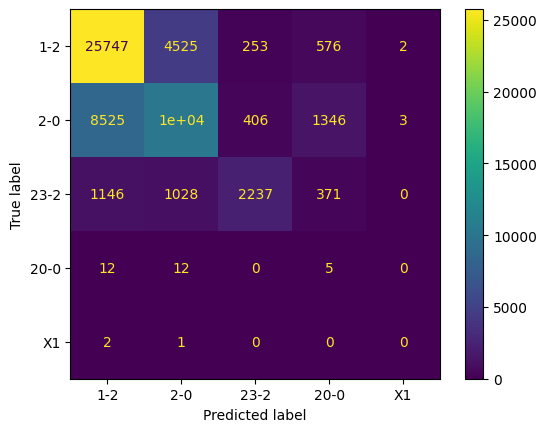

In [9]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['1-2', '2-0', '23-2', '20-0','X1'])

cm_display.plot()
plt.show()